# Cluster interpolation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
from dataloader import UTKFaceDataset
import seaborn as sns
import pandas as pd
from ae import AutoEncoderNet
from torchvision.utils import make_grid
from sklearn import metrics
from sklearn.cluster import KMeans
from matplotlib import gridspec
from sklearn import metrics


## Data and model

In [2]:
BATCH_SIZE = 64
DEVICE = "cpu"

dataset = UTKFaceDataset(data_type="test", gray_scale=False)
test_loader = torch.utils.data.DataLoader(dataset,batch_size= BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

model_path = "models/AutoEncoder_256.pt"
model = AutoEncoderNet(n_channels=3, dim_last_layer=(64, 21, 21), latent_features=256)
model.load_state_dict(torch.load(model_path))
model.to(DEVICE)
model.eval()

# zs = []
# ys = []
# for i, (x, y) in enumerate(test_loader):
#     mu = model.encoder(x.to(DEVICE))
#     zs.append(mu.detach().cpu())
#     ys.append(y.cpu())

# z = torch.concat(zs)
# y = torch.concat(ys)

# # np.save("Z.npy", z.numpy())
# # np.save("Y.npy", y.numpy())

z = np.load("Z.npy")
y = np.load("Y.npy")
assert (y-dataset.y).sum().sum() == 0
x = dataset.X

## K-means

,age,gender,race,cluster
0,35,1,2,4
1,26,0,0,6
2,90,0,0,1
3,28,0,1,5
4,60,1,1,5
...,...,...,...,...
4736,40,0,0,7
4737,27,0,0,16
4738,16,0,0,20
4739,50,0,2,4


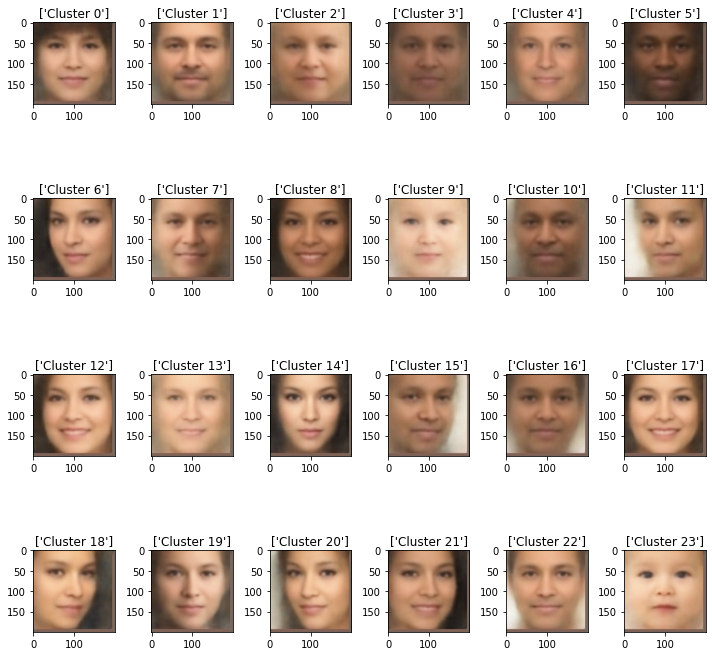

In [3]:
kmeans = KMeans(n_clusters=24, random_state = 42)
labels = kmeans.fit_predict(z)
df = pd.DataFrame({"age":y[:,0], "gender" : y[:,1], "race" : y[:,2], "cluster":labels})
display(df)

## Visualize cluster centers
C = kmeans.cluster_centers_ # the cluster means
resp = kmeans.labels_ # a vector of the cluster number for each observation

gs = gridspec.GridSpec(4, 6)
fig = plt.figure(figsize=(10,10))
for i in range(len(C)):
    ax = fig.add_subplot(gs[i])
    latent = torch.from_numpy(C[i]).unsqueeze(0).to(DEVICE).float()
    c = model.decoder(latent).detach().cpu().squeeze().permute(1, 2, 0).numpy()
    ax.imshow(c)
    ax.set_title(['Cluster %d' %i])
    ax.set_aspect('equal', adjustable='box')

fig.tight_layout()
plt.show()


## Interpolate clusters

### Age

Text(0.5, 1.0, 'Interpolation between two clusters')

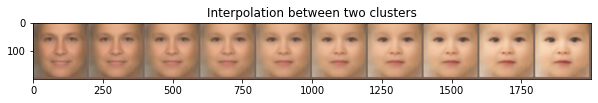

In [12]:
c_young, c_old = df.groupby("cluster").mean().sort_values("age").index[[0, -1]]

z1 = torch.from_numpy(C[c_young])
z1 = z1.unsqueeze(0).to(DEVICE)

z2 = torch.from_numpy(C[c_old])
z2 = z2.unsqueeze(0).to(DEVICE)

alphas = torch.linspace(0,1,steps=10)
model.eval()
plt.figure(figsize=(10,5))

recs = []
for alpha in alphas:
    z_mixed = alpha*z1 + (1-alpha)*z2
    z_mixed = z_mixed.to(DEVICE)
    rec = model.decoder(z_mixed.float())
    rec = rec.squeeze().detach().permute(1, 2, 0).cpu().numpy()
    recs.append(rec)
plt.imshow(np.concatenate(recs,axis=1))
plt.title("Interpolation between two cluster centers")

Text(0.5, 1.0, 'Interpolation between two cluster centers')

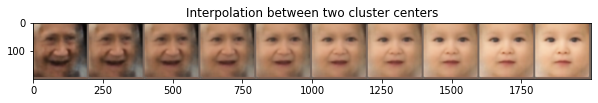

In [16]:
z1 = torch.from_numpy(C[c_young])
z1 = z1.unsqueeze(0).to(DEVICE)

z2 = z[np.argmax(y[: , 0])]

alphas = torch.linspace(0,1,steps=10)
model.eval()
plt.figure(figsize=(10,5))

recs = []
for alpha in alphas:
    z_mixed = alpha*z1 + (1-alpha)*z2
    z_mixed = z_mixed.to(DEVICE)
    rec = model.decoder(z_mixed.float())
    rec = rec.squeeze().detach().permute(1, 2, 0).cpu().numpy()
    recs.append(rec)
plt.imshow(np.concatenate(recs,axis=1))
plt.title("Interpolation between youngest cluster and oldest image")

## Aging Lukas


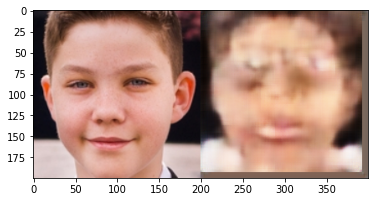

In [20]:
import PIL

# img = PIL.Image.open("../data/custom/10428214_10202361461859555_4415941076778582031_o (4) (1).jpg")
img = PIL.Image.open("../data/custom/young_lukas3.jpg")
# img = PIL.Image.open("../data/custom/matilde.jpg")
# img = torch.tensor(np.array(img)).permute(2, 0, 1).unsqueeze(0).to("cpu")

# img  = "../data/custom/young_lukas.jpg"

trans = transforms.Compose([
    transforms.Resize(200),
    transforms.CenterCrop(200), 
    transforms.ToTensor()
])

img = trans(img)

img.size()

latent,rec = model(img.unsqueeze(0))
rec = rec.detach().squeeze()


plt.imshow(np.concatenate((img.permute(1, 2, 0),rec.permute(1,2,0)),axis=1))